In [38]:
# Importations et réglage de la reproductibilité
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras import layers, Model, Input, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import gradio as gr

# Pour la reproductibilité
tf.random.set_seed(42)
np.random.seed(42)

In [36]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 27.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 97.0 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
# Définition des groupes d'âge (si vous souhaitez les utiliser pour une autre tâche)
age_groups = [
    (0, 9), (10, 19), (20, 29), (30, 39), (40, 49),
    (50, 59), (60, 69), (70, 79), (80, 89), (90, 99), (100, 120)
]
num_age_groups = len(age_groups)

def age_to_group(age, age_groups=age_groups):
    """Convertit un âge en indice de groupe."""
    for idx, (low, high) in enumerate(age_groups):
        if low <= age <= high:
            return idx
    return num_age_groups - 1

In [39]:
# Fonctions d'extraction et de chargement du dataset UTKFace
def extract_age_gender(filename):
    """Extrait l'âge et le genre du nom de fichier UTKFace."""
    parts = filename.split("_")
    age = int(parts[0])
    gender = int(parts[1])
    return age, gender

def load_dataset(image_folder):
    """Charge les chemins d'image et labels depuis le dossier UTKFace."""
    image_files = [f for f in os.listdir(image_folder) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    image_paths = [os.path.join(image_folder, f) for f in image_files]
    ages, genders = zip(*[extract_age_gender(f) for f in image_files])
    return image_paths, list(ages), list(genders)

# Définir le chemin vers le dataset
DATA_DIR = "/kaggle/input/utkface-new/UTKFace"
image_paths, ages, genders = load_dataset(DATA_DIR)

# Mélanger les données
image_paths, ages, genders = shuffle(image_paths, ages, genders, random_state=42)

# Séparation en ensembles train et validation (80% / 20%)
train_paths, val_paths, train_ages, val_ages, train_genders, val_genders = train_test_split(
    image_paths, ages, genders, test_size=0.2, random_state=42
)

print("Nombre d'images d'entraînement :", len(train_paths))
print("Nombre d'images de validation   :", len(val_paths))

Nombre d'images d'entraînement : 18966
Nombre d'images de validation   : 4742


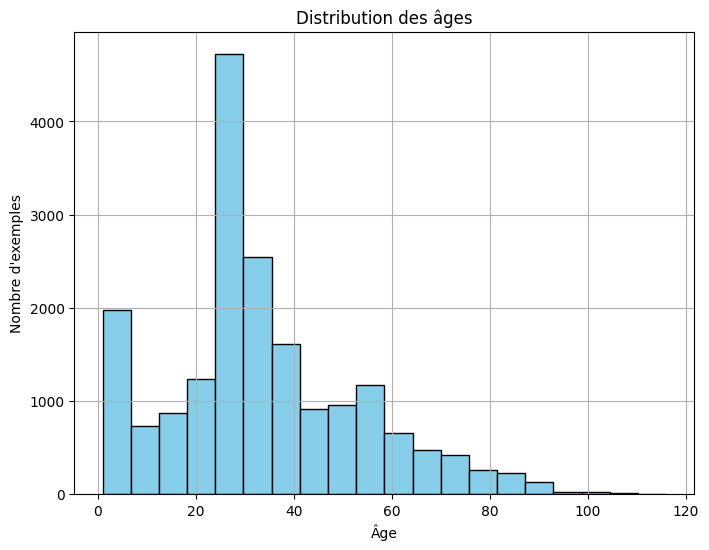

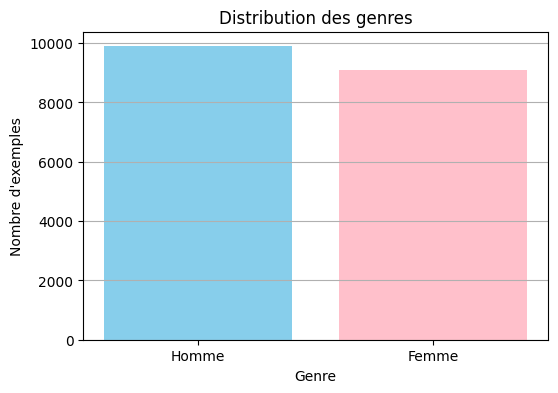

In [40]:
# Visualisation des distributions (utile pour comprendre le dataset)
def plot_age_distribution(ages):
    plt.figure(figsize=(8, 6))
    plt.hist(ages, bins=20, color='skyblue', edgecolor='black')
    plt.title("Distribution des âges")
    plt.xlabel("Âge")
    plt.ylabel("Nombre d'exemples")
    plt.grid(True)
    plt.show()

def plot_gender_distribution(genders):
    gender_labels = ["Homme", "Femme"]
    counts = [genders.count(0), genders.count(1)]
    plt.figure(figsize=(6, 4))
    plt.bar(gender_labels, counts, color=['skyblue', 'pink'])
    plt.title("Distribution des genres")
    plt.xlabel("Genre")
    plt.ylabel("Nombre d'exemples")
    plt.grid(axis='y')
    plt.show()

plot_age_distribution(train_ages)
plot_gender_distribution(train_genders)

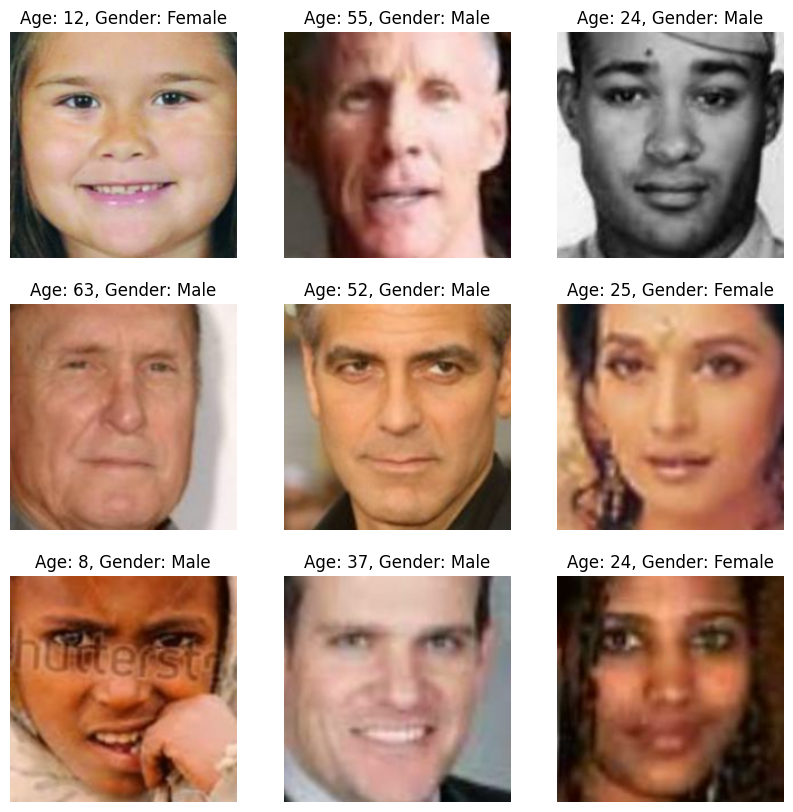

In [41]:
# --- Fonctions de prétraitement ---
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

def process_path_train(path, age, gender, image_size=IMAGE_SIZE):
    """Prétraitement pour l'entraînement avec data augmentation et EfficientNet preprocessing."""
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_size)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = efficientnet_preprocess(image) # Use EfficientNet preprocessing
    normalized_age = tf.cast(age, tf.float32) / 116.0 # Normalize age to [0, 1]
    return image, {'age_output': normalized_age, 'gender_output': tf.cast(gender, tf.float32)}

def process_path_val(path, age, gender, image_size=IMAGE_SIZE):
    """Prétraitement pour la validation avec EfficientNet preprocessing (sans augmentation)."""
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_size)
    image = efficientnet_preprocess(image) # Use EfficientNet preprocessing
    normalized_age = tf.cast(age, tf.float32) / 116.0 # Normalize age to [0, 1]
    return image, {'age_output': normalized_age, 'gender_output': tf.cast(gender, tf.float32)}

# --- Création des datasets ---
def create_dataset(paths, ages, genders, process_func, batch_size=BATCH_SIZE, shuffle_buffer=1000):
    ds = tf.data.Dataset.from_tensor_slices((paths, ages, genders))
    ds = ds.map(lambda p, a, g: process_func(p, a, g, IMAGE_SIZE), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.shuffle(shuffle_buffer) # Shuffle only for training dataset
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = create_dataset(train_paths, train_ages, train_genders, process_path_train)
val_ds = create_dataset(val_paths, val_ages, val_genders, process_path_val, shuffle_buffer=1) # No need to shuffle validation

# --- Visualisation d'un batch pour vérifier le prétraitement ---
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9): # Display 9 images from the batch
        plt.subplot(3, 3, i + 1)
        image = tf.keras.preprocessing.image.array_to_img(images[i]) # Convert back to PIL image for display if needed
        plt.imshow(image)
        age = labels['age_output'][i].numpy() * 116
        gender = "Female" if labels['gender_output'][i].numpy() >= 0.5 else "Male"
        plt.title(f"Age: {age:.0f}, Gender: {gender}")
        plt.axis('off')
    plt.show()

In [42]:
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

IMAGE_SIZE = (224, 224)

# --- Hyperparamètres Ajustés pour Augmenter la Capacité et la Régularisation ---
L2_FACTOR = 0.0005      # **Réduction Légère de L2** (de 0.001 à 0.0005) -  Peut-être trop de régularisation ?
DROPOUT_RATE = 0.5      # **On garde Dropout à 0.5 pour la 1ère couche** - Régularisation forte
LEARNING_RATE = 1e-4    # Taux d'apprentissage (on garde pour l'instant)
DENSE_UNITS_LAYER1 = 1024 # **On garde la grande taille de la 1ère couche** (1024 unités)
DENSE_UNITS_LAYER2 = 512  # **On garde la taille de la 2e couche** (512 unités)

# Définition de l'entrée
input_tensor = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# Charger EfficientNetB2 sans les couches de classification
base_model_efficientnet = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
base_model_efficientnet.trainable = False # On garde la base gelée pour l'instant

# --- Tête de classification personnalisée (couches denses AUGMENTÉES et Dropout Ajusté) ---
x = base_model_efficientnet(input_tensor)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)

# Couches denses - TAILLES GRANDES et DROPOUT AJUSTÉ
x = layers.Dense(DENSE_UNITS_LAYER1, activation='relu', kernel_regularizer=l2(L2_FACTOR))(x) # **1ère couche dense (1024 unités)**
x = layers.Dropout(DROPOUT_RATE)(x) # **Dropout à 0.5 (inchangé)** - Régularisation forte
x = layers.Dense(DENSE_UNITS_LAYER2, activation='relu', kernel_regularizer=l2(L2_FACTOR))(x) # **2e couche dense (512 unités)**
x = layers.Dropout(DROPOUT_RATE)(x) # **Dropout REVIENT à 0.5 pour la 2e couche** - Régularisation plus forte aussi ici

# Couches de sortie (inchangées)
age_output = layers.Dense(1, activation='linear', name='age_output')(x)
gender_output = layers.Dense(1, activation='sigmoid', name='gender_output')(x)

# Créer le modèle EfficientNetB4
model_efficientnetB1 = Model(inputs=input_tensor, outputs=[age_output, gender_output])

# Afficher le résumé du modèle
model_efficientnetB1.summary()

# Compilation du modèle (inchangée)
model_efficientnetB1.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                     loss={'age_output': 'mae', 'gender_output': 'binary_crossentropy'},
                     metrics={'age_output': 'mae', 'gender_output': 'accuracy'})

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ efficientnetb1            │ (None, 7, 7, 1280)     │      6,575,239 │ input_layer_12[0][0]   │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1280)           │              0 │ efficientnetb1[0][0]   │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 1280)           │          5,120 │ global_average_poolin… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_18 (Dense)          │ (None, 1024)           │      1,311,744 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_18 (Dropout)      │ (None, 1024)           │              0 │ dense_18[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_19 (Dense)          │ (None, 512)            │        524,800 │ dropout_18[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_19 (Dropout)      │ (None, 512)            │              0 │ dense_19[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ age_output (Dense)        │ (None, 1)              │            513 │ dropout_19[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gender_output (Dense)     │ (None, 1)              │            513 │ dropout_19[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 8,417,929 (32.11 MB)

 Trainable params: 1,840,130 (7.02 MB)

 Non-trainable params: 6,577,799 (25.09 MB)

In [43]:
# Entraînement du modèle avec callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    #ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
    ModelCheckpoint(filepath='/kaggle/working/checkpoints/b_efficientnetb1_age_gender.keras',
                    monitor='val_loss', save_best_only=True, mode='min', verbose=1)
]

history_efficientnet = model_efficientnetB1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50, 
    callbacks=callbacks
)

Epoch 1/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - age_output_loss: 0.8555 - age_output_mae: 0.8555 - gender_output_accuracy: 0.7417 - gender_output_loss: 0.5323 - loss: 2.2937
Epoch 1: val_loss improved from inf to 1.40088, saving model to /kaggle/working/checkpoints/b_efficientnetb1_age_gender.keras
593/593 ━━━━━━━━━━━━━━━━━━━━ 95s 114ms/step - age_output_loss: 0.8551 - age_output_mae: 0.8551 - gender_output_accuracy: 0.7417 - gender_output_loss: 0.5322 - loss: 2.2932 - val_age_output_loss: 0.1642 - val_age_output_mae: 0.1642 - val_gender_output_accuracy: 0.8564 - val_gender_output_loss: 0.3435 - val_loss: 1.4009
Epoch 2/50
592/593 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - age_output_loss: 0.3126 - age_output_mae: 0.3126 - gender_output_accuracy: 0.8269 - gender_output_loss: 0.3766 - loss: 1.5769
Epoch 2: val_loss improved from 1.40088 to 1.33111, saving model to /kaggle/working/checkpoints/b_efficientnetb1_age_gender.keras
593/593 ━━━━━━━━━━━━━━━━━━━━ 42s 69ms/step - age_output_loss: 

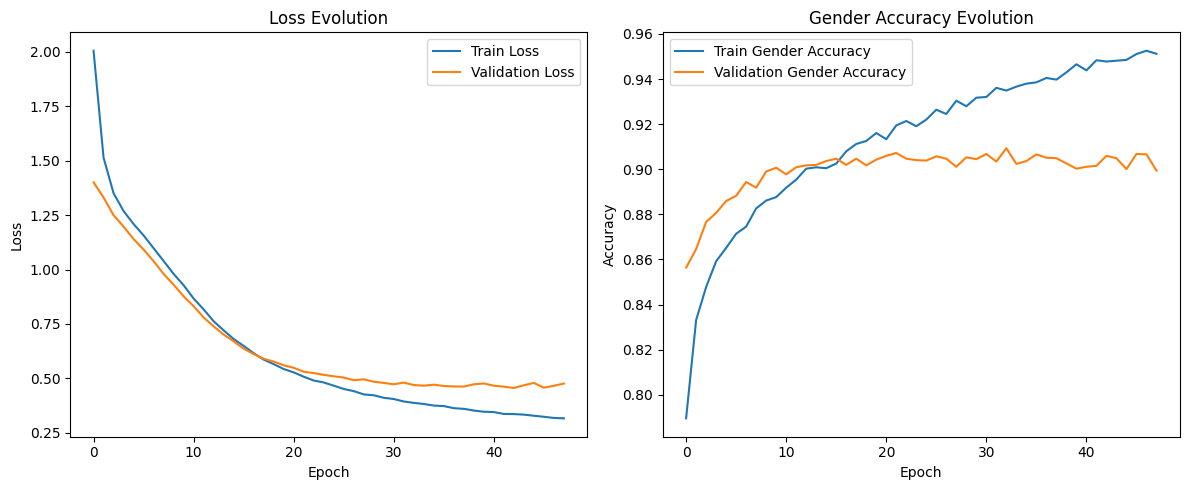

In [44]:
# Visualisation des courbes d'apprentissage
def plot_training_curves(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['gender_output_accuracy'], label='Train Gender Accuracy')
    plt.plot(history.history['val_gender_output_accuracy'], label='Validation Gender Accuracy')
    plt.title('Gender Accuracy Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_curves(history_efficientnet)

In [45]:
def age_accuracy(y_true, y_pred, tol=5.0):
    """
    Calcule l'accuracy pour la prédiction de l'âge.
    On considère qu'une prédiction est correcte si l'erreur absolue
    (en années) est inférieure ou égale à tol (par défaut 5 ans).

    Les valeurs y_true et y_pred sont supposées être normalisées (ex : divisées par 120).
    """
    # Dénormalisation (si l'âge maximum est 120)
    y_true_denorm = y_true * 116.0
    y_pred_denorm = y_pred * 116.0
    # Calcul de la différence absolue
    diff = tf.abs(y_true_denorm - y_pred_denorm)
    # On considère la prédiction correcte si diff <= tol
    correct = tf.cast(tf.less_equal(diff, tol), tf.float32)
    # Retourne la proportion de prédictions correctes
    return tf.reduce_mean(correct)

print("age_accuracy function defined (check if this line prints after running)")

age_accuracy function defined (check if this line prints after running)



--- Évaluation de la Prédiction de l'Âge ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 

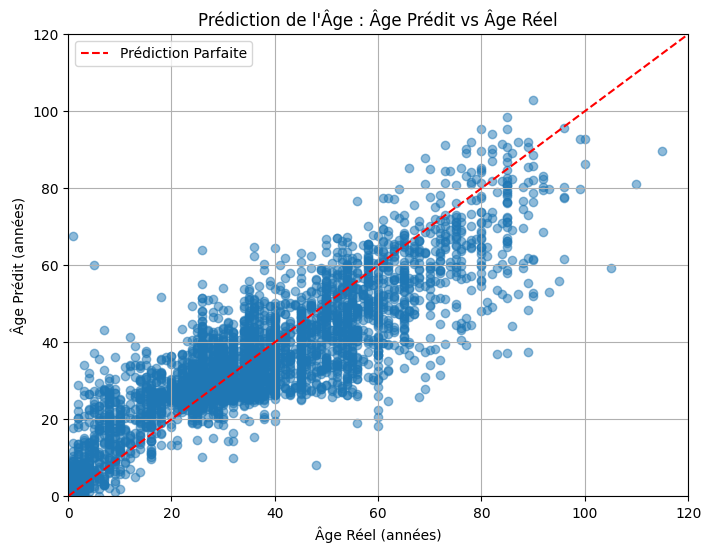

In [59]:
# %% [code]
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate_age_performance(model, val_ds):
    """
    Évalue la performance de la prédiction de l'âge et affiche les métriques.
    """
    true_ages = []
    predicted_ages_normalized = []

    for images, labels in val_ds:
        true_ages.extend(labels['age_output'].numpy())
        predicted_ages_batch_normalized = model.predict(images)[0] # Index 0 pour l'âge
        predicted_ages_normalized.extend(predicted_ages_batch_normalized.flatten())

    true_ages = np.array(true_ages) * 116.0  # Dénormaliser les âges réels
    predicted_ages = np.array(predicted_ages_normalized) * 116.0 # Dénormaliser les âges prédits

    # Calcul des métriques de régression
    mae = mean_absolute_error(true_ages, predicted_ages)
    mse = mean_squared_error(true_ages, predicted_ages)
    rmse = np.sqrt(mse)

    print("\nMétriques de Régression pour l'Âge :")
    print(f"  Mean Absolute Error (MAE): {mae:.2f} years")
    print(f"  Mean Squared Error (MSE): {mse:.2f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.2f}")

    # Graphique de dispersion (Scatter plot) : Prédit vs Réel
    plt.figure(figsize=(8, 6))
    plt.scatter(true_ages, predicted_ages, alpha=0.5)
    plt.plot([0, 120], [0, 120], linestyle='--', color='r', label='Prédiction Parfaite') # Ligne de référence pour prédiction parfaite
    plt.xlabel("Âge Réel (années)")
    plt.ylabel("Âge Prédit (années)")
    plt.title("Prédiction de l'Âge : Âge Prédit vs Âge Réel")
    plt.xlim([0, 120]) # Limiter l'échelle pour la plage d'âge typique
    plt.ylim([0, 120])
    plt.legend()
    plt.grid(True)
    plt.show()


# Appel de la fonction d'évaluation de l'âge après l'évaluation du genre
print("\n--- Évaluation de la Prédiction de l'Âge ---")
evaluate_age_performance(model_efficientnetB1, val_ds) # Make sure to use the correct model name here, e.g., model_efficientnet_v2, not model_efficientnet_v0 as in your error message

149/149 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - age_output_loss: 0.0603 - age_output_mae: 0.0603 - gender_output_accuracy: 0.9117 - gender_output_loss: 0.2519 - loss: 0.4462
Validation Loss (Total): 0.4554920494556427
Validation Age MAE: 0.05917524918913841
Validation Gender Accuracy: 0.9059468507766724
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━

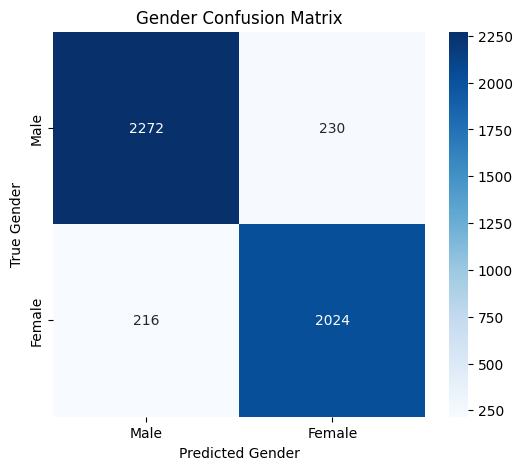

In [49]:
# Évaluation détaillée sur l'ensemble de validation
def evaluate_gender_performance(model, val_ds):
    """Evaluates gender classification and prints metrics."""
    true_genders = []
    predicted_genders_probs = []
    for images, labels in val_ds:
        true_genders.extend(labels['gender_output'].numpy())
        predicted_gender_probs_batch = model.predict(images)[1] # Index 1 for gender
        predicted_genders_probs.extend(predicted_gender_probs_batch.flatten())

    predicted_genders = np.round(predicted_genders_probs)
    true_genders = np.array(true_genders)
    predicted_genders = np.array(predicted_genders)

    print("\nConfusion Matrix:")
    cm = confusion_matrix(true_genders, predicted_genders)
    print(cm)

    print("\nClassification Report:")
    print(classification_report(true_genders, predicted_genders))

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Male', 'Female'], yticklabels=['Male', 'Female'])
    plt.xlabel('Predicted Gender')
    plt.ylabel('True Gender')
    plt.title('Gender Confusion Matrix')
    plt.show()

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

results_val = model_efficientnetB1.evaluate(val_ds)
print("Validation Loss (Total):", results_val[0])
print("Validation Age MAE:", results_val[1])
print("Validation Gender Accuracy:", results_val[4]) # Index 4 for gender accuracy

evaluate_gender_performance(model_efficientnetB1, val_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


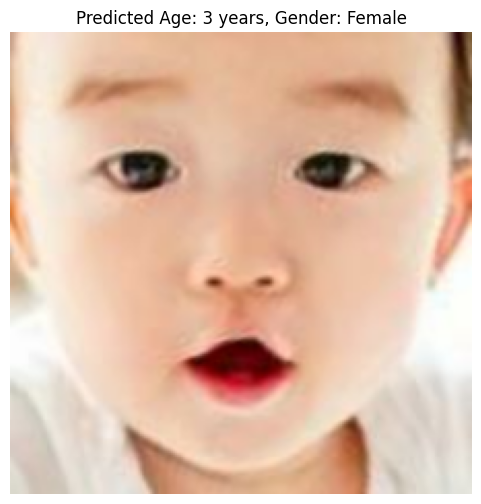

Image Path: /kaggle/input/utkface-new/UTKFace/2_0_2_20161219212035798.jpg.chip.jpg
Predicted Age: 3 years, Predicted Gender: Female


In [53]:
# Fonction d'inférence pour une image à partir du chemin
def inference_age_gender_from_path_v2(model, image_path, image_size=IMAGE_SIZE, plot=False):
    """Inférence âge et genre à partir d'un chemin d'image."""
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_size)
    image = efficientnet_preprocess(image) # Use EfficientNet preprocessing
    input_tensor = tf.expand_dims(image, axis=0) # Add batch dimension
    predictions = model.predict(input_tensor)
    predicted_age_normalized = predictions[0][0][0] # Age output is the first output
    predicted_age = predicted_age_normalized * 120 # Denormalize age
    predicted_gender_prob = predictions[1][0][0] # Gender output is the second output
    predicted_gender = "Female" if predicted_gender_prob >= 0.5 else "Male"

    if plot:
        plt.figure(figsize=(6, 6))
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image)) # Convert back to PIL for display
        plt.title(f"Predicted Age: {predicted_age:.0f} years, Gender: {predicted_gender}")
        plt.axis('off')
        plt.show()
    return predicted_age, predicted_gender

# Exemple d'inférence
sample_image_path = val_paths[np.random.randint(0, len(val_paths))] # Get random val image path
predicted_age, predicted_gender = inference_age_gender_from_path_v2(
    model_efficientnetB1, sample_image_path, plot=True
)
print(f"Image Path: {sample_image_path}")
print(f"Predicted Age: {predicted_age:.0f} years, Predicted Gender: {predicted_gender}")

In [ ]:
# Gradio Interface
def gradio_inference(img):
    """Gradio wrapper function for interactive inference."""
    img_array = np.array(img)
    img_resized = tf.image.resize(img_array, IMAGE_SIZE)
    img_preprocessed = efficientnet_preprocess(img_resized) # Use EfficientNet preprocessing
    input_tensor = tf.expand_dims(img_preprocessed, axis=0)
    predictions = model_efficientnet_v3.predict(input_tensor)
    pred_age = predictions[0][0][0] * 120
    pred_gender_prob = predictions[1][0][0]
    gender_label = "Female" if pred_gender_prob >= 0.5 else "Male"
    return f"Predicted Age: {pred_age:.0f} years, Predicted Gender: {gender_label}"

iface = gr.Interface(
    fn=gradio_inference,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Age and Gender Prediction with EfficientNetB2",
    description="Upload a face image to predict age and gender."
)
iface.launch(share=True)

149/149 ━━━━━━━━━━━━━━━━━━━━ 22s 78ms/step - age_output_loss: 0.0654 - age_output_mae: 0.0654 - gender_output_accuracy: 0.9047 - gender_output_loss: 0.2366 - loss: 0.3925
Validation Loss (Total): 0.3947509825229645
Validation Age MAE: 0.064301997423172
Validation Gender Accuracy: 0.9053142070770264
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━

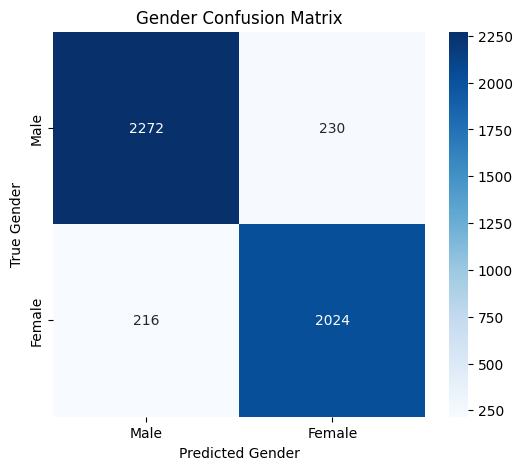

In [51]:
def evaluate_gender_performance(model, val_ds):
    """Evaluates gender classification and prints metrics."""
    true_genders = []
    predicted_genders_probs = []
    for images, labels in val_ds:
        true_genders.extend(labels['gender_output'].numpy())
        predicted_gender_probs_batch = model.predict(images)[1] # Index 1 for gender
        predicted_genders_probs.extend(predicted_gender_probs_batch.flatten())

    predicted_genders = np.round(predicted_genders_probs)
    true_genders = np.array(true_genders)
    predicted_genders = np.array(predicted_genders)

    print("\nConfusion Matrix:")
    cm = confusion_matrix(true_genders, predicted_genders)
    print(cm)

    print("\nClassification Report:")
    print(classification_report(true_genders, predicted_genders))

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Male', 'Female'], yticklabels=['Male', 'Female'])
    plt.xlabel('Predicted Gender')
    plt.ylabel('True Gender')
    plt.title('Gender Confusion Matrix')
    plt.show()

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

results_val = model_efficientnetb1.evaluate(val_ds)
print("Validation Loss (Total):", results_val[0])
print("Validation Age MAE:", results_val[1])
print("Validation Gender Accuracy:", results_val[4]) # Index 4 for gender accuracy

evaluate_gender_performance(model_efficientnetB1, val_ds)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


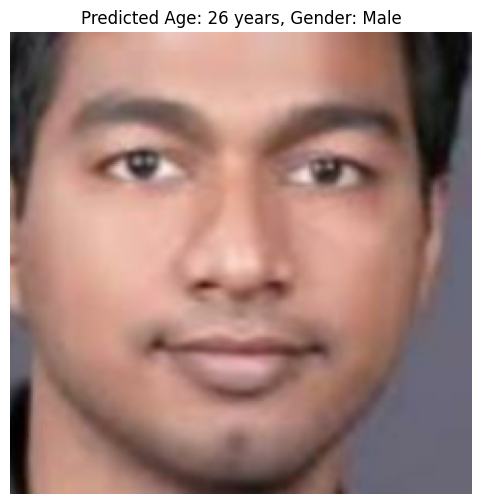

Image Path: /kaggle/input/utkface-new/UTKFace/23_0_3_20170119164051638.jpg.chip.jpg
Predicted Age: 26 years, Predicted Gender: Male


In [54]:
# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2025-03-05T19:18:28.001921Z","iopub.execute_input":"2025-03-05T19:18:28.002215Z","iopub.status.idle":"2025-03-05T19:18:33.477039Z","shell.execute_reply.started":"2025-03-05T19:18:28.002192Z","shell.execute_reply":"2025-03-05T19:18:33.476180Z"}}
# Fonction d'inférence pour une image à partir du chemin
def inference_age_gender_from_path_v2(model, image_path, image_size=IMAGE_SIZE, plot=False):
    """Inférence âge et genre à partir d'un chemin d'image."""
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_size)
    image = efficientnet_preprocess(image) # Use EfficientNet preprocessing
    input_tensor = tf.expand_dims(image, axis=0) # Add batch dimension
    predictions = model.predict(input_tensor)
    predicted_age_normalized = predictions[0][0][0] # Age output is the first output
    predicted_age = predicted_age_normalized * 116 # Denormalize age
    predicted_gender_prob = predictions[1][0][0] # Gender output is the second output
    predicted_gender = "Female" if predicted_gender_prob >= 0.5 else "Male"

    if plot:
        plt.figure(figsize=(6, 6))
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image)) # Convert back to PIL for display
        plt.title(f"Predicted Age: {predicted_age:.0f} years, Gender: {predicted_gender}")
        plt.axis('off')
        plt.show()
    return predicted_age, predicted_gender

# Exemple d'inférence
sample_image_path = val_paths[np.random.randint(0, len(val_paths))] # Get random val image path
predicted_age, predicted_gender = inference_age_gender_from_path_v2(
    model_efficientnetB1, sample_image_path, plot=True
)
print(f"Image Path: {sample_image_path}")
print(f"Predicted Age: {predicted_age:.0f} years, Predicted Gender: {predicted_gender}")



In [ ]:
# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2025-02-10T16:37:27.241825Z","iopub.execute_input":"2025-02-10T16:37:27.242086Z","iopub.status.idle":"2025-02-10T16:37:29.505957Z","shell.execute_reply.started":"2025-02-10T16:37:27.242063Z","shell.execute_reply":"2025-02-10T16:37:29.505090Z"}}
# Gradio Interface
def gradio_inference(img):
    """Gradio wrapper function for interactive inference."""
    img_array = np.array(img)
    img_resized = tf.image.resize(img_array, IMAGE_SIZE)
    img_preprocessed = efficientnet_preprocess(img_resized) # Use EfficientNet preprocessing
    input_tensor = tf.expand_dims(img_preprocessed, axis=0)
    predictions = model_efficientnet_v2.predict(input_tensor)
    pred_age = predictions[0][0][0] * 116
    pred_gender_prob = predictions[1][0][0]
    gender_label = "Female" if pred_gender_prob >= 0.5 else "Male"
    return f"Predicted Age: {pred_age:.0f} years, Predicted Gender: {gender_label}"

iface = gr.Interface(
    fn=gradio_inference,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Age and Gender Prediction with EfficientNetB2",
    description="Upload a face image to predict age and gender."
)
iface.launch(share=True)



Métriques de Régression pour l'Âge (Validation):
  MAE : 6.86 ans
  MSE : 92.93
  RMSE: 9.64
  Accuracy within 10 ans: 77.01%

--- Évaluation par Classes d'Âge ---
Confusion matrix:
[[ 453  106   65   10    1    0    2    0    0    0    0]
 [  12   78  159   40    1    1    0    0    0    0    0]
 [   0   19 1196  341   50    7    1    0    0    0    0]
 [   1    5  313  305  116   18    3    0    0    0    0]
 [   1    1   66  182  143   35    5    0    0    0    0]
 [   0    2   26  110  188  148   47    2    0    0    0]
 [   0    0    3   18   46   65   59   12    3    0    0]
 [   0    0    0    7   16   32   44   24   12    3    0]
 [   0    0    0    3    5   16   27   26   22   10    0]
 [   0    0    0    0    0    4    4    7    7    2    1]
 [   0    0    0    0    0    1    0    0    3    1    0]]


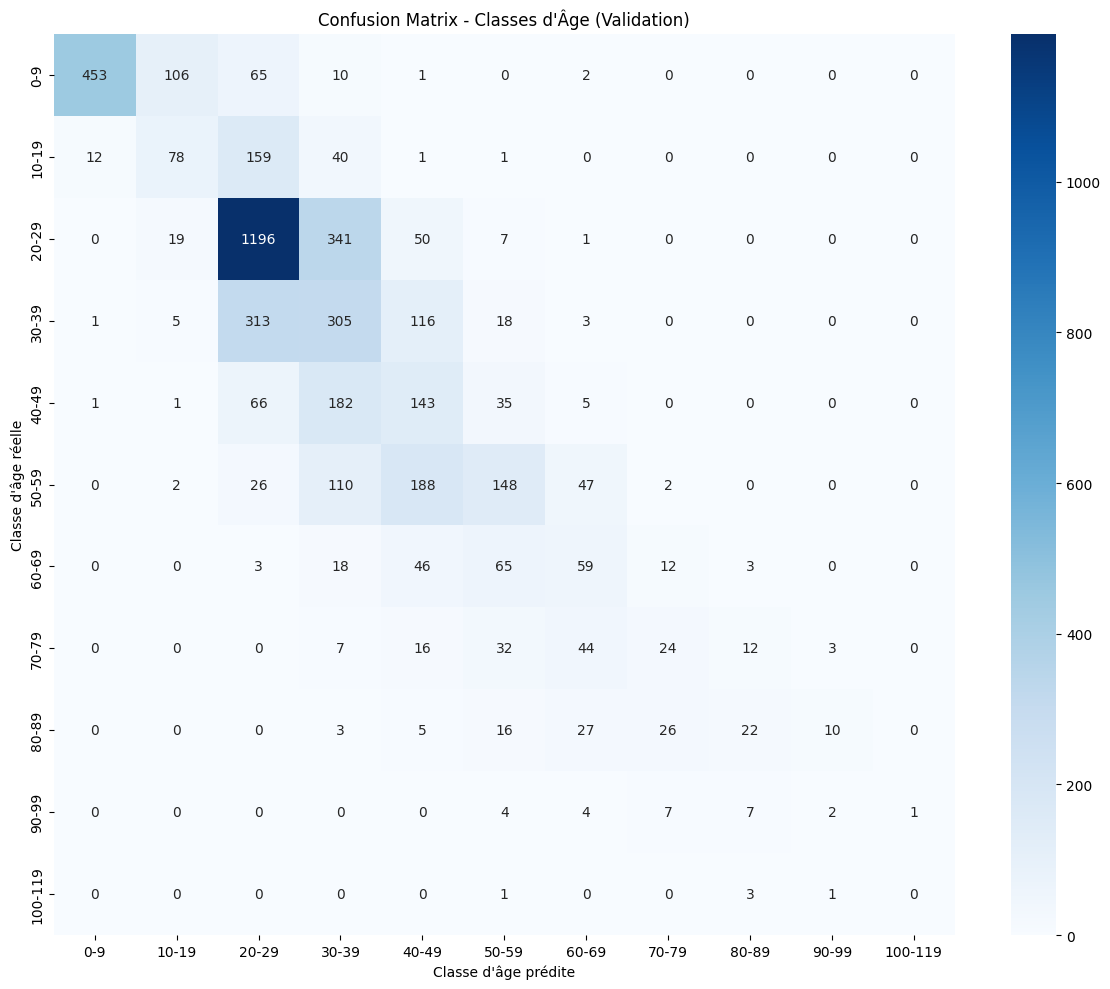


Classification Report (Classes d'Âge):
              precision    recall  f1-score   support

         0-9       0.97      0.71      0.82       637
       10-19       0.37      0.27      0.31       291
       20-29       0.65      0.74      0.69      1614
       30-39       0.30      0.40      0.34       761
       40-49       0.25      0.33      0.29       433
       50-59       0.45      0.28      0.35       523
       60-69       0.31      0.29      0.30       206
       70-79       0.34      0.17      0.23       138
       80-89       0.47      0.20      0.28       109
       90-99       0.12      0.08      0.10        25
     100-119       0.00      0.00      0.00         5

    accuracy                           0.51      4742
   macro avg       0.39      0.32      0.34      4742
weighted avg       0.53      0.51      0.51      4742



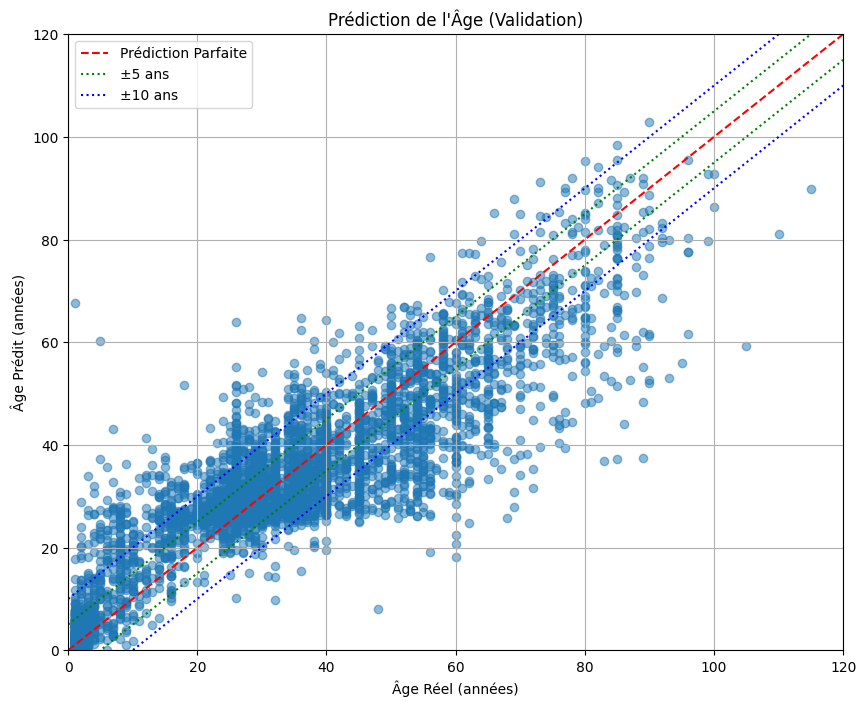

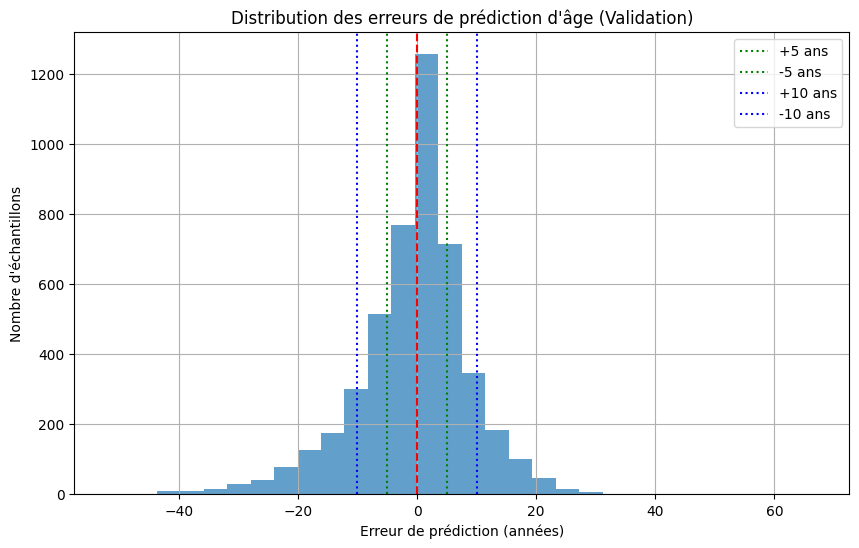

(6.8630013,
 0.7701391817798398,
 array([[ 453,  106,   65,   10,    1,    0,    2,    0,    0,    0,    0],
        [  12,   78,  159,   40,    1,    1,    0,    0,    0,    0,    0],
        [   0,   19, 1196,  341,   50,    7,    1,    0,    0,    0,    0],
        [   1,    5,  313,  305,  116,   18,    3,    0,    0,    0,    0],
        [   1,    1,   66,  182,  143,   35,    5,    0,    0,    0,    0],
        [   0,    2,   26,  110,  188,  148,   47,    2,    0,    0,    0],
        [   0,    0,    3,   18,   46,   65,   59,   12,    3,    0,    0],
        [   0,    0,    0,    7,   16,   32,   44,   24,   12,    3,    0],
        [   0,    0,    0,    3,    5,   16,   27,   26,   22,   10,    0],
        [   0,    0,    0,    0,    0,    4,    4,    7,    7,    2,    1],
        [   0,    0,    0,    0,    0,    1,    0,    0,    3,    1,    0]]))

In [60]:

# %% [code] {"execution":{"iopub.status.busy":"2025-03-05T19:18:33.478266Z","iopub.execute_input":"2025-03-05T19:18:33.478583Z","iopub.status.idle":"2025-03-05T19:18:50.585799Z","shell.execute_reply.started":"2025-03-05T19:18:33.478550Z","shell.execute_reply":"2025-03-05T19:18:50.585076Z"}}
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def evaluate_age_performance(model, val_dataset, stage="Validation"):
    """
    Évalue la performance de la prédiction de l'âge :
      - Calcul des métriques de régression (MAE, MSE, RMSE, accuracy within 5 & 10 ans)
      - Conversion des âges continus en classes d'âge et calcul de la confusion matrix.
    """
    true_ages = []
    pred_ages_norm = []
    
    # Collecte des prédictions
    for images, labels in val_dataset:
        true_ages.extend(labels['age_output'].numpy())
        preds = model.predict(images, verbose=0)[0]  # Prédictions de l'âge
        pred_ages_norm.extend(preds.flatten())
    
    true_ages = np.array(true_ages) * 116.0
    pred_ages = np.array(pred_ages_norm) * 116.0
    
    # Métriques de régression
    mae = mean_absolute_error(true_ages, pred_ages)
    mse = mean_squared_error(true_ages, pred_ages)
    rmse = np.sqrt(mse)
   
    acc_10 = np.mean(np.abs(true_ages - pred_ages) <= 10.0)  # Accuracy à ±10 ans
    
    print(f"\nMétriques de Régression pour l'Âge ({stage}):")
    print(f"  MAE : {mae:.2f} ans")
    print(f"  MSE : {mse:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  Accuracy within 10 ans: {acc_10*100:.2f}%")
    
    # Définition des tranches d'âge
    age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120]
    age_labels = [f"{age_bins[i]}-{age_bins[i+1]-1}" for i in range(len(age_bins)-1)]
    
    # Classification des âges en tranches
    true_bin_indices = np.digitize(true_ages, age_bins) - 1
    pred_bin_indices = np.digitize(pred_ages, age_bins) - 1
    
    # Correction des indices hors limites
    true_bin_indices = np.clip(true_bin_indices, 0, len(age_labels)-1)
    pred_bin_indices = np.clip(pred_bin_indices, 0, len(age_labels)-1)
    
    # Conversion des indices en noms de classes
    true_bins = [age_labels[i] for i in true_bin_indices]
    pred_bins = [age_labels[i] for i in pred_bin_indices]
    
    # Matrice de confusion
    print("\n--- Évaluation par Classes d'Âge ---")
    cm = confusion_matrix(true_bins, pred_bins, labels=age_labels)
    print("Confusion matrix:")
    print(cm)
    
    # Visualisation de la matrice de confusion
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=age_labels, yticklabels=age_labels)
    plt.xlabel("Classe d'âge prédite")
    plt.ylabel("Classe d'âge réelle")
    plt.title(f"Confusion Matrix - Classes d'Âge ({stage})")
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_age_{stage.lower()}.png')
    plt.show()
    
    # Rapport de classification
    print("\nClassification Report (Classes d'Âge):")
    print(classification_report(true_bins, pred_bins, labels=age_labels, zero_division=0))
    
    # Scatter plot pour comparer les âges réels et prédits
    plt.figure(figsize=(10, 8))
    plt.scatter(true_ages, pred_ages, alpha=0.5)
    plt.plot([0, 120], [0, 120], linestyle='--', color='r', label='Prédiction Parfaite')
    
    # Ajout des lignes de tolérance pour ±5 ans et ±10 ans
    plt.plot([0, 120], [5, 125], linestyle=':', color='g', label='±5 ans')
    plt.plot([0, 120], [-5, 115], linestyle=':', color='g')
    plt.plot([0, 120], [10, 130], linestyle=':', color='b', label='±10 ans')
    plt.plot([0, 120], [-10, 110], linestyle=':', color='b')
    
    plt.xlabel("Âge Réel (années)")
    plt.ylabel("Âge Prédit (années)")
    plt.title(f"Prédiction de l'Âge ({stage})")
    plt.xlim([0, 120])
    plt.ylim([0, 120])
    plt.legend()
    plt.grid(True)
    plt.savefig(f'age_prediction_scatter_{stage.lower()}.png')
    plt.show()
    
    # Histogramme des erreurs
    errors = pred_ages - true_ages
    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=30, alpha=0.7)
    plt.axvline(x=0, color='r', linestyle='--')
    plt.axvline(x=5, color='g', linestyle=':', label='+5 ans')
    plt.axvline(x=-5, color='g', linestyle=':', label='-5 ans')
    plt.axvline(x=10, color='b', linestyle=':', label='+10 ans')
    plt.axvline(x=-10, color='b', linestyle=':', label='-10 ans')
    plt.xlabel("Erreur de prédiction (années)")
    plt.ylabel("Nombre d'échantillons")
    plt.title(f"Distribution des erreurs de prédiction d'âge ({stage})")
    plt.legend()
    plt.grid(True)
    plt.savefig(f'age_error_distribution_{stage.lower()}.png')
    plt.show()
    
    return mae, acc_10, cm


evaluate_age_performance(model_efficientnetB1, val_ds, stage="Validation")

# %% [code]